In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
games = pd.read_csv('games.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv')
tackles = pd.read_csv('tackles.csv')
df = pd.read_csv('new_df.csv', index_col=0)

In [3]:
df[df['pff_missedTackle'] == 1]['playId'].unique()

array([1102, 1385, 2163, ..., 3037, 3174, 3480], dtype=int64)

In [4]:
df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'isCarrier', 'isTackler', 'isAssistant', 'forcedFumble',
       'pff_missedTackle', 'footballDistance', 'carrierDistance',
       'orientationDifference', 'motionAngleDifference', 'speedDifference'],
      dtype='object')

In [5]:
df

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,...,0.0,0.0,0.0,0.0,0.0,7.334439,13.483816,91.69,41.48,-4.61
1,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,...,0.0,0.0,0.0,0.0,0.0,9.256266,11.013632,135.85,142.29,-4.99
2,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.200000,99.0,LA,left,91.08,...,0.0,0.0,0.0,0.0,0.0,6.418790,12.427904,28.28,57.36,-2.32
3,2022090800,56,42392.0,Mitch Morse,1,2022-09-08 20:24:05.200000,60.0,BUF,left,88.25,...,0.0,0.0,0.0,0.0,0.0,5.995406,12.236217,104.16,159.09,-5.56
4,2022090800,56,42489.0,Stefon Diggs,1,2022-09-08 20:24:05.200000,14.0,BUF,left,80.60,...,42489.0,0.0,0.0,0.0,0.0,6.314500,0.000000,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187212,2022110700,3787,54476.0,Chris Olave,44,2022-11-07 23:06:49.599999,12.0,NO,right,29.35,...,0.0,0.0,0.0,0.0,0.0,10.151217,10.241079,72.64,149.62,0.14
12187213,2022110700,3787,54541.0,Travis Jones,44,2022-11-07 23:06:49.599999,98.0,BAL,right,24.96,...,0.0,0.0,0.0,0.0,0.0,1.530523,1.450310,18.79,150.47,0.09
12187214,2022110700,3787,54606.0,Damarion Williams,44,2022-11-07 23:06:49.599999,22.0,BAL,right,33.38,...,0.0,0.0,0.0,0.0,0.0,11.906141,11.895819,108.91,75.57,0.74
12187215,2022110700,3787,55125.0,Lewis Kidd,44,2022-11-07 23:06:49.599999,66.0,NO,right,23.91,...,0.0,0.0,0.0,0.0,0.0,2.930614,2.827083,9.48,128.87,1.11


Deleting last 4 frame Ids

In [6]:
#df = df[df.groupby(['gameId', 'playId', 'nflId']).cumcount(ascending=False) >= 4].reset_index()
df = df[(df.groupby(['gameId', 'playId', 'nflId']).cumcount() >= 5) & (df.groupby(['gameId', 'playId', 'nflId']).cumcount(ascending=False) >= 4)].reset_index()
df['frameId'] = df['frameId'] - 5
df.drop(columns=['index'], inplace=True)

In [7]:
tacklers = df[(df['event']=='tackle') & (df['isTackler']!=0)]

In [8]:
df[(df['event']=='tackle') & (df['isTackler']!=0)].groupby('club')['s'].mean().sort_values(ascending=False)

club
DAL    2.952400
DET    2.678689
NYG    2.650383
LV     2.650079
WAS    2.642798
ARI    2.631496
GB     2.582231
SF     2.570490
KC     2.546624
NE     2.534640
BUF    2.532910
PHI    2.523896
TB     2.513220
JAX    2.504618
MIN    2.495731
TEN    2.487581
SEA    2.487173
DEN    2.475524
CAR    2.457289
ATL    2.448472
BAL    2.446506
CHI    2.420704
NO     2.416032
MIA    2.407665
IND    2.404915
LA     2.403550
PIT    2.355513
HOU    2.345763
CLE    2.344000
CIN    2.297413
LAC    2.286225
NYJ    2.034109
Name: s, dtype: float64

In [9]:
df[(df['gameId']==2022100913) & (df['playId']==293) & (df['frameId']==63)].drop(columns={'dir', 'dis'})

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference


In [10]:
tacklers[tacklers['carrierDistance']>3]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference
8246,2022090800,414,52647.0,Dane Jackson,30,2022-09-08 20:36:27.099999,30.0,BUF,right,59.73,...,0.0,1.0,0.0,0.0,0.0,2.785823,3.032375,152.98,130.46,-2.19
57047,2022090800,3576,40107.0,Micah Hyde,65,2022-09-08 23:03:17.700000,23.0,BUF,left,26.67,...,0.0,1.0,0.0,0.0,0.0,3.594356,3.918074,106.08,220.43,-4.54
96927,2022091100,2114,53469.0,Richie Grant,44,2022-09-11 14:45:43.099999,27.0,ATL,left,64.53,...,0.0,1.0,0.0,0.0,0.0,4.858241,4.880461,201.03,35.76,-4.24
126958,2022091100,4032,53469.0,Richie Grant,5,2022-09-11 16:01:46.599999,27.0,ATL,right,67.69,...,0.0,1.0,0.0,0.0,0.0,3.159050,3.620842,79.22,286.12,1.13
127845,2022091100,4307,40017.0,Tyrann Mathieu,17,2022-09-11 16:09:34.099999,32.0,NO,left,71.35,...,0.0,1.0,0.0,0.0,0.0,3.901859,3.838880,197.74,151.21,-2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9096178,2022110610,2875,47971.0,David Long,24,2022-11-06 22:34:14.200000,51.0,TEN,left,57.47,...,0.0,1.0,0.0,0.0,1.0,3.558779,3.608545,4.15,120.62,-2.84
9141765,2022110700,1532,52665.0,Malcolm Roach,63,2022-11-07 21:17:50.500000,97.0,NO,left,24.30,...,0.0,1.0,0.0,0.0,0.0,3.246799,3.394775,109.81,24.15,-2.47
9147455,2022110700,2043,44851.0,Marcus Maye,49,2022-11-07 21:49:57.400000,6.0,NO,right,51.24,...,0.0,1.0,0.0,0.0,0.0,3.940051,4.400284,4.58,294.77,-1.98
9150105,2022110700,2131,53505.0,Paulson Adebo,48,2022-11-07 21:52:52.299999,29.0,NO,right,72.47,...,0.0,1.0,0.0,0.0,0.0,4.508347,4.434242,103.22,115.87,-1.76


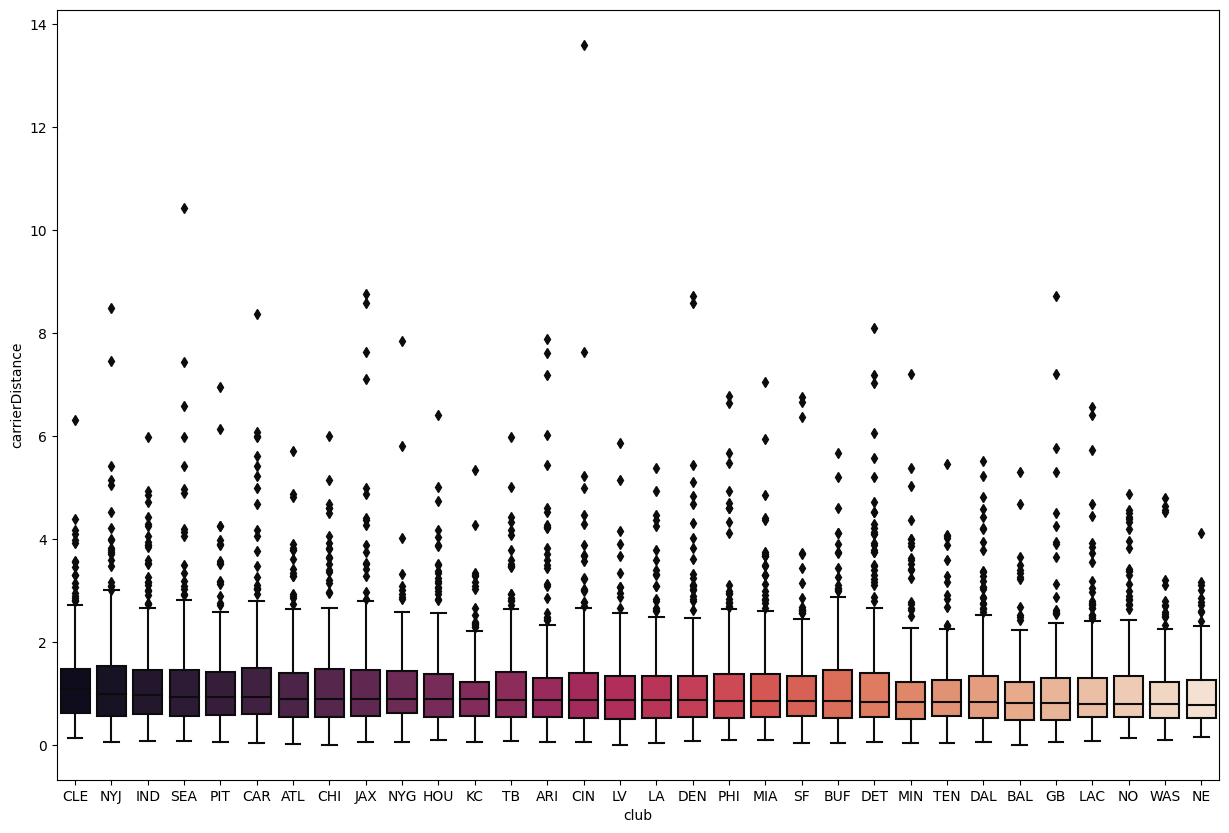

In [11]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='club', y='carrierDistance', data=tacklers, palette='rocket', order=tacklers.groupby('club')['carrierDistance'].median().sort_values(ascending=False).index)
plt.show()

In [12]:
ari = tacklers[tacklers['club']=='ARI']
ari['x'] = ari.apply(lambda row: 120-row['x'] if row['playDirection']=='right' else row['x'], axis=1)

<Axes: xlabel='x', ylabel='y'>

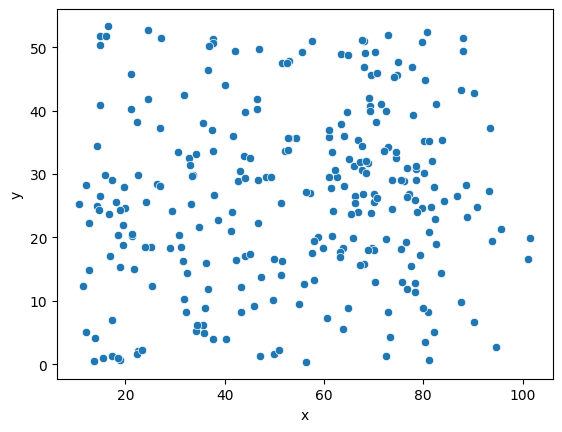

In [13]:
sns.scatterplot(x='x', y='y', data=ari, palette='rocket')

In [14]:
cle = tacklers[tacklers['club']=='CLE']
cle['x'] = cle.apply(lambda row: 120-row['x'] if row['playDirection']=='right' else row['x'], axis=1)

<Axes: xlabel='x', ylabel='y'>

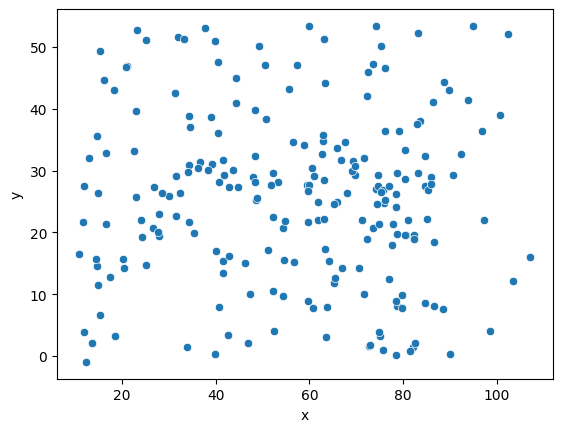

In [15]:
sns.scatterplot(x='x', y='y', data=cle, palette='rocket')

In [16]:
df.groupby('club')['s'].mean()

club
ARI    2.741958
ATL    3.021085
BAL    2.761487
BUF    2.919439
CAR    2.916630
CHI    3.058996
CIN    2.721952
CLE    2.734583
DAL    2.868752
DEN    2.759463
DET    2.926788
GB     2.771525
HOU    2.886664
IND    2.763458
JAX    2.866042
KC     2.855221
LA     2.702212
LAC    2.654741
LV     2.800156
MIA    3.016862
MIN    2.746525
NE     2.739885
NO     2.748837
NYG    2.958113
NYJ    2.891746
PHI    2.673546
PIT    2.640691
SEA    2.944169
SF     2.810436
TB     2.669237
TEN    3.115626
WAS    2.783787
Name: s, dtype: float64

[]

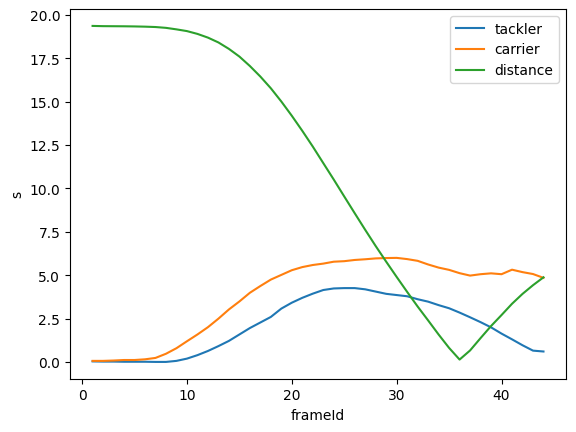

In [17]:
sns.lineplot(data = df[(df['gameId']==2022091100)&(df['playId']==2114)&(df['nflId']==53469)], x='frameId', y='s', label='tackler')
sns.lineplot(data = df[(df['gameId']==2022091100)&(df['playId']==2114)&(df['nflId']==45244)], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022091100)&(df['playId']==2114)&(df['nflId']==53469)], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

In [18]:
df[(df['gameId']==2022090800)&(df['playId']==56)&(df['nflId']==	43294)].iloc[5:-4, :]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference
116,2022090800,56,43294.0,Jalen Ramsey,6,2022-09-08 20:24:06.200000,5.0,LA,left,78.22,...,0.0,1.0,0.0,0.0,0.0,2.271254,1.523056,43.54,29.50,2.23
138,2022090800,56,43294.0,Jalen Ramsey,7,2022-09-08 20:24:06.299999,5.0,LA,left,78.25,...,0.0,1.0,0.0,0.0,0.0,2.706013,1.308167,48.67,25.12,2.22
160,2022090800,56,43294.0,Jalen Ramsey,8,2022-09-08 20:24:06.400000,5.0,LA,left,78.29,...,0.0,1.0,0.0,0.0,0.0,2.598556,1.122943,45.45,16.01,2.06
182,2022090800,56,43294.0,Jalen Ramsey,9,2022-09-08 20:24:06.500000,5.0,LA,left,78.35,...,0.0,1.0,0.0,0.0,0.0,2.879339,0.967988,37.71,0.48,1.79


[]

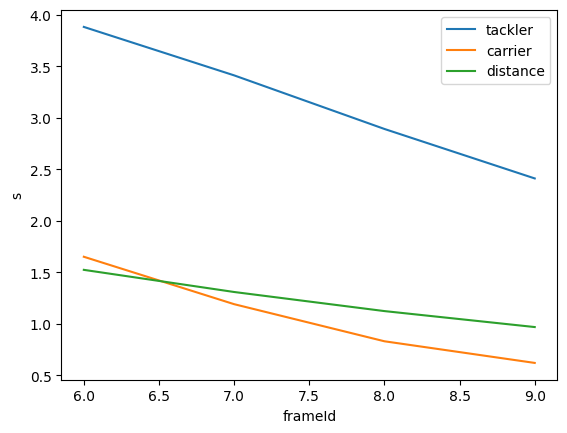

In [19]:
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==56)&(df['nflId']==	43294)].iloc[5:-4, :], x='frameId', y='s', label='tackler')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==56)&(df['nflId']==42489)].iloc[5:-4, :], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==56)&(df['nflId']==	43294)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

[]

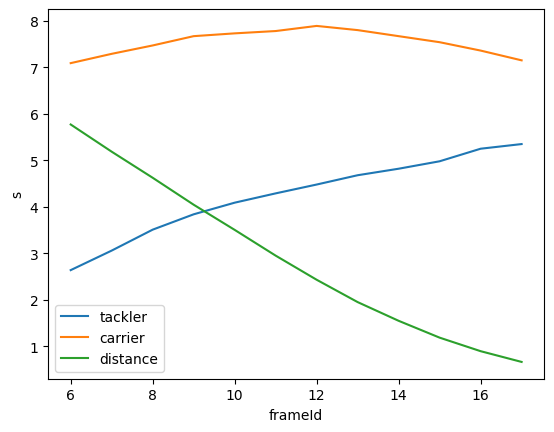

In [20]:
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==80)&(df['isTackler']==	1)].iloc[5:-4, :], x='frameId', y='s', label='tackler')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==80)&(df['isCarrier']!=0)].iloc[5:-4, :], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==80)&(df['isTackler']==	1)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

[]

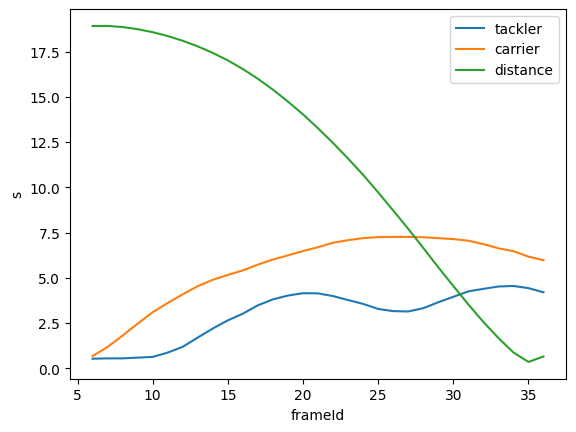

In [21]:
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==101)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='s', label='tackler')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==101)&(df['isCarrier']!=0)].iloc[5:-4, :], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==101)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

[]

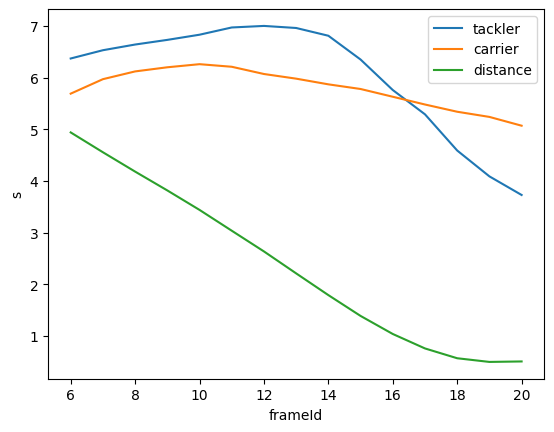

In [22]:
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==122)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='s', label='tackler')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==122)&(df['isCarrier']!=0)].iloc[5:-4, :], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==122)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

[]

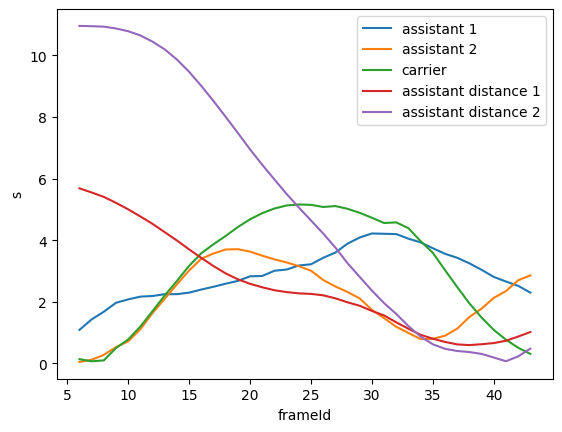

In [23]:
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==146)&(df['isAssistant']==1)&(df['nflId']==43335)].iloc[5:-4, :], x='frameId', y='s', label='assistant 1')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==146)&(df['isAssistant']==1)&(df['nflId']==38577)].iloc[5:-4, :], x='frameId', y='s', label='assistant 2')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==146)&(df['isCarrier']!=0)].iloc[5:-4, :], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==146)&(df['isAssistant']==1)&(df['nflId']==43335)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='assistant distance 1')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==146)&(df['isAssistant']==1)&(df['nflId']==38577)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='assistant distance 2')
plt.legend()
plt.plot()

[]

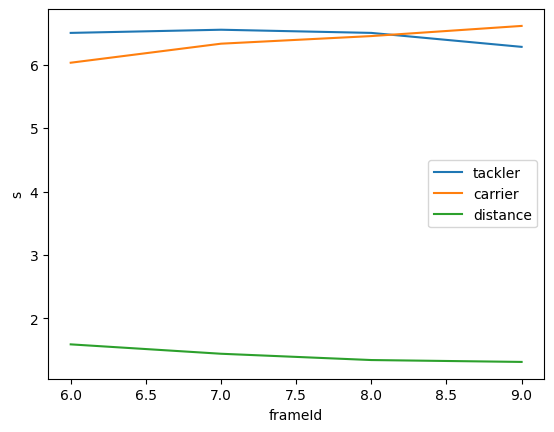

In [24]:
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==167)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='s', label='tackler')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==167)&(df['isCarrier']!=0)].iloc[5:-4, :], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==167)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

## Example of missed tackle

[]

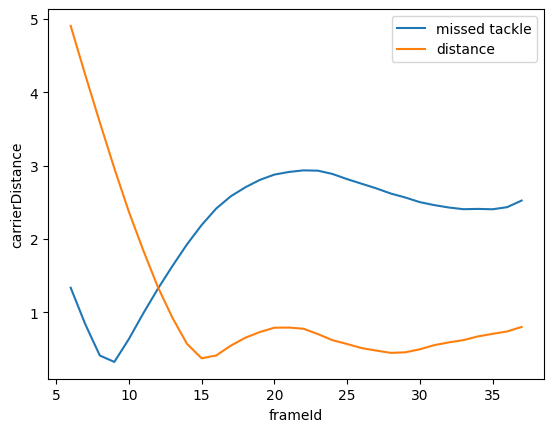

In [25]:
#sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1102)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='s', label='tackler')
#sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1102)&(df['isCarrier']!=0)].iloc[5:-4, :], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1102)&(df['pff_missedTackle']!=0)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='missed tackle')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1102)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

[]

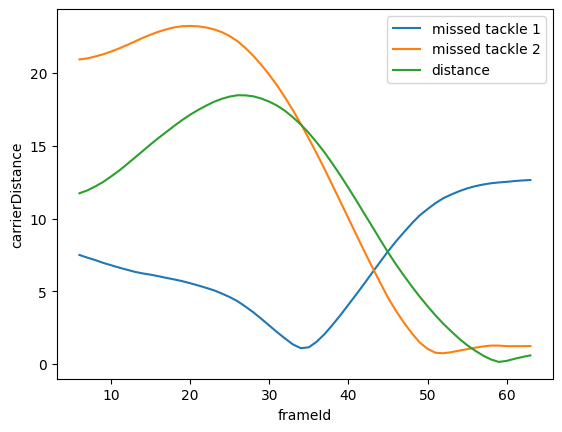

In [26]:
#sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1385)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='s', label='tackler')
#sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1385)&(df['isCarrier']!=0)].iloc[5:-4, :], x='frameId', y='s', label='carrier')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1385)&(df['nflId']==46232)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='missed tackle 1')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1385)&(df['nflId']==40107)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='missed tackle 2')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==1385)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

[]

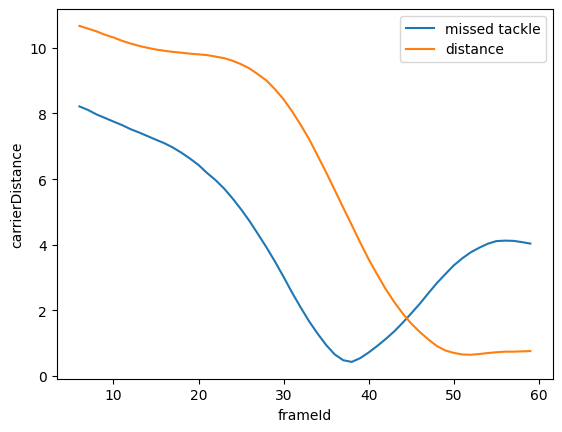

In [27]:
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==2163)&(df['pff_missedTackle']!=0)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='missed tackle')
sns.lineplot(data = df[(df['gameId']==2022090800)&(df['playId']==2163)&(df['isTackler']==1)].iloc[5:-4, :], x='frameId', y='carrierDistance', label='distance')
plt.legend()
plt.plot()

In [28]:
df[(df['gameId']==2022090800)&(df['playId']==2163)&(df['pff_missedTackle']==1)].iloc[5:-4, :]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference
30192,2022090800,2163,43335.0,A'Shawn Robinson,6,2022-09-08 22:00:43.299999,94.0,LA,left,44.43,...,0.0,0.0,0.0,0.0,1.0,3.605732,8.215625,172.84,27.81,-0.04
30214,2022090800,2163,43335.0,A'Shawn Robinson,7,2022-09-08 22:00:43.400000,94.0,LA,left,44.49,...,0.0,0.0,0.0,0.0,1.0,3.734715,8.107928,169.26,26.12,-0.43
30236,2022090800,2163,43335.0,A'Shawn Robinson,8,2022-09-08 22:00:43.500000,94.0,LA,left,44.55,...,0.0,0.0,0.0,0.0,1.0,3.874856,7.972961,166.12,25.18,-0.92
30258,2022090800,2163,43335.0,A'Shawn Robinson,9,2022-09-08 22:00:43.599999,94.0,LA,left,44.56,...,0.0,0.0,0.0,0.0,1.0,4.085731,7.864000,160.56,17.59,-1.13
30280,2022090800,2163,43335.0,A'Shawn Robinson,10,2022-09-08 22:00:43.700000,94.0,LA,left,44.55,...,0.0,0.0,0.0,0.0,1.0,4.296707,7.754180,150.39,12.03,-1.36
30302,2022090800,2163,43335.0,A'Shawn Robinson,11,2022-09-08 22:00:43.799999,94.0,LA,left,44.50,...,0.0,0.0,0.0,0.0,1.0,4.584234,7.647653,138.33,7.56,-1.56
30324,2022090800,2163,43335.0,A'Shawn Robinson,12,2022-09-08 22:00:43.900000,94.0,LA,left,44.44,...,0.0,0.0,0.0,0.0,1.0,4.941711,7.523091,122.32,4.68,-1.72
30346,2022090800,2163,43335.0,A'Shawn Robinson,13,2022-09-08 22:00:44.000000,94.0,LA,left,44.34,...,0.0,0.0,0.0,0.0,1.0,5.361568,7.422432,99.57,2.27,-1.77
30368,2022090800,2163,43335.0,A'Shawn Robinson,14,2022-09-08 22:00:44.099999,94.0,LA,left,44.21,...,0.0,0.0,0.0,0.0,1.0,5.866941,7.311094,94.16,0.45,-1.73
30390,2022090800,2163,43335.0,A'Shawn Robinson,15,2022-09-08 22:00:44.200000,94.0,LA,left,44.05,...,0.0,0.0,0.0,0.0,1.0,6.324636,7.199125,82.86,0.57,-1.82


In [29]:
df[(df['gameId']==2022090800)&(df['playId']==167)&(df['event']=='tackle')]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference
3454,2022090800,167,35472.0,Rodger Saffold,13,2022-09-08 20:27:12.099999,76.0,BUF,left,64.50,...,0.0,0.0,0.0,0.0,0.0,18.987159,18.970888,256.03,95.16,-4.95
3455,2022090800,167,38577.0,Bobby Wagner,13,2022-09-08 20:27:12.099999,45.0,LA,left,47.31,...,0.0,0.0,0.0,0.0,0.0,2.150000,2.110095,5.65,27.33,-1.77
3456,2022090800,167,41239.0,Aaron Donald,13,2022-09-08 20:27:12.099999,99.0,LA,left,64.02,...,0.0,0.0,0.0,0.0,0.0,18.861203,18.850215,22.13,89.23,-4.13
3457,2022090800,167,42392.0,Mitch Morse,13,2022-09-08 20:27:12.099999,60.0,BUF,left,61.63,...,0.0,0.0,0.0,0.0,0.0,16.042805,16.023608,10.74,54.85,-4.64
3458,2022090800,167,42489.0,Stefon Diggs,13,2022-09-08 20:27:12.099999,14.0,BUF,left,45.61,...,42489.0,0.0,0.0,0.0,0.0,0.044722,0.000000,0.00,0.00,0.00
3459,2022090800,167,42816.0,Troy Hill,13,2022-09-08 20:27:12.099999,2.0,LA,left,42.12,...,0.0,0.0,0.0,0.0,0.0,6.234846,6.212866,255.25,103.26,-0.19
3460,2022090800,167,43294.0,Jalen Ramsey,13,2022-09-08 20:27:12.099999,5.0,LA,left,47.88,...,0.0,0.0,0.0,0.0,0.0,17.559960,17.597028,16.89,41.17,-2.44
3461,2022090800,167,43298.0,Leonard Floyd,13,2022-09-08 20:27:12.099999,54.0,LA,left,46.84,...,0.0,1.0,0.0,0.0,0.0,1.582213,1.591540,50.77,4.62,-1.55
3462,2022090800,167,43335.0,A'Shawn Robinson,13,2022-09-08 20:27:12.099999,94.0,LA,left,62.12,...,0.0,0.0,0.0,0.0,0.0,16.836891,16.824913,67.59,44.72,-4.88
3463,2022090800,167,44875.0,Dion Dawkins,13,2022-09-08 20:27:12.099999,73.0,BUF,left,61.69,...,0.0,0.0,0.0,0.0,0.0,16.277899,16.252261,12.29,38.93,-3.33


In [30]:
df[(df['gameId']==2022090800)]['playId'].unique()

array([  56,   80,  101,  122,  146,  167,  191,  212,  236,  299,  343,
        364,  393,  414,  438,  486,  529,  569,  593,  617,  646,  692,
        775,  818,  867,  896,  933,  980, 1030, 1102, 1187, 1230, 1254,
       1286, 1334, 1358, 1385, 1406, 1563, 1712, 1736, 1757, 1836, 1946,
       1967, 2043, 2072, 2093, 2137, 2163, 2184, 2208, 2232, 2307, 2336,
       2360, 2464, 2485, 2506, 2527, 2551, 2572, 2599, 2648, 2688, 2712,
       2755, 2815, 2839, 2860, 2884, 2934, 2958, 2979, 3092, 3121, 3145,
       3166, 3190, 3262, 3283, 3304, 3341, 3362, 3383, 3407, 3431, 3489,
       3513, 3576, 3636], dtype=int64)

In [31]:
df[(df['gameId']==2022090800)&(df['playId']==56)].head(20)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.700000,76.0,BUF,left,88.80,...,0.0,0.0,0.0,0.0,0.0,15.140187,12.614856,120.21,62.79,-3.46
1,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.700000,45.0,LA,left,78.11,...,0.0,0.0,0.0,0.0,0.0,8.790687,7.067538,235.20,155.51,-1.26
2,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.700000,99.0,LA,left,92.15,...,0.0,0.0,0.0,0.0,0.0,15.854014,13.527265,71.89,44.55,-0.99
3,2022090800,56,42392.0,Mitch Morse,1,2022-09-08 20:24:05.700000,60.0,BUF,left,88.21,...,0.0,0.0,0.0,0.0,0.0,12.937096,10.456003,168.05,144.95,-3.19
4,2022090800,56,42489.0,Stefon Diggs,1,2022-09-08 20:24:05.700000,14.0,BUF,left,79.85,...,42489.0,0.0,0.0,0.0,0.0,2.533869,0.000000,0.00,0.00,0.00
5,2022090800,56,42816.0,Troy Hill,1,2022-09-08 20:24:05.700000,2.0,LA,left,70.62,...,0.0,0.0,0.0,0.0,0.0,30.821694,29.415605,217.30,76.13,-2.01
6,2022090800,56,43294.0,Jalen Ramsey,1,2022-09-08 20:24:05.700000,5.0,LA,left,78.15,...,0.0,1.0,0.0,0.0,0.0,0.327568,2.828003,26.69,23.70,1.27
7,2022090800,56,43298.0,Leonard Floyd,1,2022-09-08 20:24:05.700000,54.0,LA,left,92.11,...,0.0,0.0,0.0,0.0,0.0,14.567229,12.502404,44.85,1.33,-3.27
8,2022090800,56,43335.0,A'Shawn Robinson,1,2022-09-08 20:24:05.700000,94.0,LA,left,88.41,...,0.0,0.0,0.0,0.0,0.0,15.651532,13.117820,112.45,68.45,-3.69
9,2022090800,56,44875.0,Dion Dawkins,1,2022-09-08 20:24:05.700000,73.0,BUF,left,89.87,...,0.0,0.0,0.0,0.0,0.0,16.264838,13.745854,141.16,183.35,-3.90


In [32]:
df[(df['gameId']==2022091100)&(df['playId']==2114)&(df['nflId']==53469)].tail(15)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference
96619,2022091100,2114,53469.0,Richie Grant,30,2022-09-11 14:45:41.700000,27.0,ATL,left,61.60,...,0.0,1.0,0.0,0.0,0.0,4.651885,4.902051,222.99,239.52,-2.14
96641,2022091100,2114,53469.0,Richie Grant,31,2022-09-11 14:45:41.799999,27.0,ATL,left,61.96,...,0.0,1.0,0.0,0.0,0.0,3.828317,4.040854,233.36,243.14,-2.14
96663,2022091100,2114,53469.0,Richie Grant,32,2022-09-11 14:45:41.900000,27.0,ATL,left,62.30,...,0.0,1.0,0.0,0.0,0.0,3.058053,3.199078,232.63,243.35,-2.21
96685,2022091100,2114,53469.0,Richie Grant,33,2022-09-11 14:45:42.000000,27.0,ATL,left,62.62,...,0.0,1.0,0.0,0.0,0.0,2.306729,2.398854,232.52,239.91,-2.14
96707,2022091100,2114,53469.0,Richie Grant,34,2022-09-11 14:45:42.099999,27.0,ATL,left,62.94,...,0.0,1.0,0.0,0.0,0.0,1.555411,1.586600,218.70,234.94,-2.16
96729,2022091100,2114,53469.0,Richie Grant,35,2022-09-11 14:45:42.200000,27.0,ATL,left,63.23,...,0.0,1.0,0.0,0.0,0.0,0.796243,0.815966,206.74,230.90,-2.21
96751,2022091100,2114,53469.0,Richie Grant,36,2022-09-11 14:45:42.299999,27.0,ATL,left,63.50,...,0.0,1.0,0.0,0.0,0.0,0.086023,0.145602,192.29,226.40,-2.27
96773,2022091100,2114,53469.0,Richie Grant,37,2022-09-11 14:45:42.400000,27.0,ATL,left,63.75,...,0.0,1.0,0.0,0.0,0.0,0.690651,0.670671,181.44,222.26,-2.40
96795,2022091100,2114,53469.0,Richie Grant,38,2022-09-11 14:45:42.500000,27.0,ATL,left,63.98,...,0.0,1.0,0.0,0.0,0.0,1.435898,1.381774,164.47,220.62,-2.76
96817,2022091100,2114,53469.0,Richie Grant,39,2022-09-11 14:45:42.599999,27.0,ATL,left,64.18,...,0.0,1.0,0.0,0.0,0.0,2.163355,2.076174,140.30,222.53,-3.11


[]

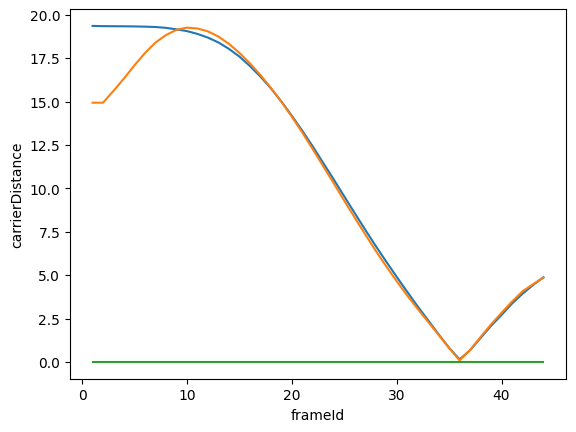

In [33]:
sns.lineplot(data = df[(df['gameId']==2022091100)&(df['playId']==2114)&(df['nflId']==53469)], x='frameId', y='carrierDistance')
sns.lineplot(data = df[(df['gameId']==2022091100)&(df['playId']==2114)&(df['nflId']==53469)], x='frameId', y='footballDistance')
sns.lineplot(data = df[(df['gameId']==2022091100)&(df['playId']==2114)&(df['nflId']==45244)], x='frameId', y='carrierDistance')
plt.plot()

## Exception

In [34]:
df[(df['gameId']==2022100913)&(df['playId']==293)&(df['event']=='tackle')]

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,isCarrier,isTackler,isAssistant,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,orientationDifference,motionAngleDifference,speedDifference
5208280,2022100913,293,38557.0,Kevin Zeitler,59,2022-10-09 20:32:38.500000,70.0,BAL,right,83.84,...,0.0,0.0,0.0,0.0,0.0,10.564550,10.478101,231.38,56.00,-4.12
5208281,2022100913,293,41295.0,Morgan Moses,59,2022-10-09 20:32:38.500000,78.0,BAL,right,85.18,...,0.0,0.0,0.0,0.0,0.0,12.344898,12.108419,239.25,65.57,-3.71
5208282,2022100913,293,43295.0,Ronnie Stanley,59,2022-10-09 20:32:38.500000,79.0,BAL,right,81.72,...,0.0,0.0,0.0,0.0,0.0,11.009178,11.090144,255.27,260.56,-4.31
5208283,2022100913,293,43299.0,Eli Apple,59,2022-10-09 20:32:38.500000,20.0,CIN,right,94.15,...,0.0,0.0,0.0,0.0,0.0,19.200753,18.716688,250.15,56.84,-0.91
5208284,2022100913,293,43350.0,Vonn Bell,59,2022-10-09 20:32:38.500000,24.0,CIN,right,92.25,...,0.0,0.0,0.0,0.0,0.0,0.631586,0.120000,236.37,70.58,1.20
5208285,2022100913,293,43415.0,Demarcus Robinson,59,2022-10-09 20:32:38.500000,10.0,BAL,right,91.51,...,0.0,0.0,0.0,0.0,0.0,19.606125,19.154300,261.10,71.15,-0.88
5208286,2022100913,293,44872.0,Chidobe Awuzie,59,2022-10-09 20:32:38.500000,22.0,CIN,right,83.61,...,0.0,0.0,0.0,0.0,0.0,10.303033,10.776048,259.39,256.04,-4.72
5208287,2022100913,293,44915.0,Trey Hendrickson,59,2022-10-09 20:32:38.500000,91.0,CIN,right,82.90,...,0.0,0.0,0.0,0.0,0.0,9.834780,9.905322,4.14,261.18,-3.96
5208288,2022100913,293,45226.0,Josh Tupou,59,2022-10-09 20:32:38.500000,68.0,CIN,right,81.47,...,0.0,0.0,0.0,0.0,0.0,11.427795,11.491249,208.07,262.05,-4.46
5208289,2022100913,293,45268.0,Patrick Ricard,59,2022-10-09 20:32:38.500000,42.0,BAL,right,83.29,...,0.0,0.0,0.0,0.0,0.0,9.303601,9.705385,11.89,264.22,-5.02


https://www.youtube.com/watch?v=CPM3yJWWYt0  (0:50)

<Axes: xlabel='x', ylabel='y'>

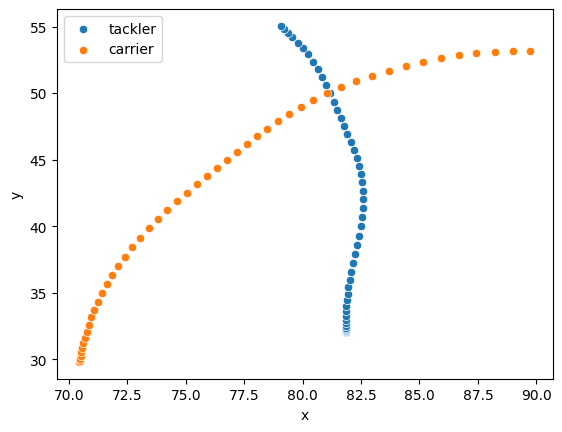

In [35]:
sns.scatterplot(data = df[(df['gameId']==2022100913)&(df['playId']==293)&(df['isTackler']==1)].iloc[5:-4, :], x='x', y='y', label='tackler')
sns.scatterplot(data = df[(df['gameId']==2022100913)&(df['playId']==293)&(df['isCarrier']!=0)].iloc[5:-4, :], x='x', y='y', label='carrier')

In [36]:
'''df['event'] = df.apply(lambda row: 'tackle' if (row['gameId'] == 2022100913 and row['playId'] == 293 and row['event'] == 'first_contact') else row['event'], axis=1)
df[(df['gameId']==2022100913)&(df['playId']==293)] = df[(df['gameId']==2022100913)&(df['playId']==293)&(df['frameId']<53)]
df['event'] = df.apply(lambda row: 'tackle' if (row['gameId'] == 2022103011 and row['playId'] == 3394 and row['event'] == 'first_contact') else row['event'], axis=1)
df[(df['gameId']==2022103011)&(df['playId']==3394)] = df[(df['gameId']==2022103011)&(df['playId']==3394)&(df['frameId']<21)]
df['event'] = df.apply(lambda row: 'tackle' if (row['gameId'] == 2022091112 and row['playId'] == 2167 and row['event'] == 'first_contact') else row['event'], axis=1)
df[(df['gameId']==2022091112)&(df['playId']==2167)] = df[(df['gameId']==2022091112)&(df['playId']==2167)&(df['frameId']<12)]'''

"df['event'] = df.apply(lambda row: 'tackle' if (row['gameId'] == 2022100913 and row['playId'] == 293 and row['event'] == 'first_contact') else row['event'], axis=1)\ndf[(df['gameId']==2022100913)&(df['playId']==293)] = df[(df['gameId']==2022100913)&(df['playId']==293)&(df['frameId']<53)]\ndf['event'] = df.apply(lambda row: 'tackle' if (row['gameId'] == 2022103011 and row['playId'] == 3394 and row['event'] == 'first_contact') else row['event'], axis=1)\ndf[(df['gameId']==2022103011)&(df['playId']==3394)] = df[(df['gameId']==2022103011)&(df['playId']==3394)&(df['frameId']<21)]\ndf['event'] = df.apply(lambda row: 'tackle' if (row['gameId'] == 2022091112 and row['playId'] == 2167 and row['event'] == 'first_contact') else row['event'], axis=1)\ndf[(df['gameId']==2022091112)&(df['playId']==2167)] = df[(df['gameId']==2022091112)&(df['playId']==2167)&(df['frameId']<12)]"

In [37]:
'''df.loc[(df['gameId'] == 2022100913) & (df['playId'] == 293) & (df['event'] == 'first_contact'), 'event'] = 'tackle'
df.loc[(df['gameId'] == 2022100913) & (df['playId'] == 293) & (df['frameId'] < 53), :] = df.loc[(df['gameId'] == 2022100913) & (df['playId'] == 293) & (df['event'] == 'first_contact') & (df['frameId'] < 53), :]'''

"df.loc[(df['gameId'] == 2022100913) & (df['playId'] == 293) & (df['event'] == 'first_contact'), 'event'] = 'tackle'\ndf.loc[(df['gameId'] == 2022100913) & (df['playId'] == 293) & (df['frameId'] < 53), :] = df.loc[(df['gameId'] == 2022100913) & (df['playId'] == 293) & (df['event'] == 'first_contact') & (df['frameId'] < 53), :]"

In [38]:
#df.loc[(df['event']=='tackle') & (df['isTackler']==1) & (df['carrierDistance']>6) & (df['event'] == 'first_contact') & (df['carrierDistance']<2.5)] = 'tackle'

In [39]:
df2 = df.copy()

In [40]:
df[(df['gameId']==2022091809)&(df['playId']==369)&(df['isTackler']==1)].drop(columns=['dir', 'dis', 'isCarrier', 'isAssistant', 'orientationDifference'])

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,a,o,event,isTackler,forcedFumble,pff_missedTackle,footballDistance,carrierDistance,motionAngleDifference,speedDifference
1692199,2022091809,369,43478.0,Anthony Brown,1,2022-09-18 16:38:10.599999,3.0,DAL,right,39.84,...,1.52,224.95,pass_outcome_caught,1.0,0.0,0.0,10.840337,10.995040,12.50,-6.14
1692221,2022091809,369,43478.0,Anthony Brown,2,2022-09-18 16:38:10.700000,3.0,DAL,right,39.86,...,1.16,224.95,0,1.0,0.0,0.0,10.718256,10.924985,11.60,-6.25
1692243,2022091809,369,43478.0,Anthony Brown,3,2022-09-18 16:38:10.799999,3.0,DAL,right,39.88,...,0.88,224.95,0,1.0,0.0,0.0,10.678699,10.878552,10.67,-6.37
1692265,2022091809,369,43478.0,Anthony Brown,4,2022-09-18 16:38:10.900000,3.0,DAL,right,40.27,...,0.85,224.95,0,1.0,0.0,0.0,10.886399,11.039420,11.21,-6.59
1692287,2022091809,369,43478.0,Anthony Brown,5,2022-09-18 16:38:11.000000,3.0,DAL,right,40.58,...,0.74,224.95,0,1.0,0.0,0.0,11.056229,11.162518,11.29,-6.70
1692309,2022091809,369,43478.0,Anthony Brown,6,2022-09-18 16:38:11.099999,3.0,DAL,right,40.59,...,0.54,224.95,0,1.0,0.0,0.0,11.081985,11.114360,9.66,-6.89
1692331,2022091809,369,43478.0,Anthony Brown,7,2022-09-18 16:38:11.200000,3.0,DAL,right,40.60,...,0.39,224.35,0,1.0,0.0,0.0,11.106368,11.091352,8.20,-7.09
1692353,2022091809,369,43478.0,Anthony Brown,8,2022-09-18 16:38:11.299999,3.0,DAL,right,40.69,...,0.29,224.35,0,1.0,0.0,0.0,11.177441,11.121016,6.53,-7.34
1692375,2022091809,369,43478.0,Anthony Brown,9,2022-09-18 16:38:11.400000,3.0,DAL,right,40.77,...,0.22,224.35,0,1.0,0.0,0.0,11.238314,11.134253,4.24,-7.51
1692397,2022091809,369,43478.0,Anthony Brown,10,2022-09-18 16:38:11.500000,3.0,DAL,right,41.09,...,0.17,223.54,0,1.0,0.0,0.0,11.319474,11.172095,2.40,-7.74


In [41]:
df = df2.copy()

In [42]:
# Step 1: Filter the DataFrame based on the condition
result_df = df[(df['isTackler'] == 1) & (df['event']=='tackle') & (df['carrierDistance'] > 5)][['gameId', 'playId', 'nflId']]

# Step 2: Get the rows where 'carrierDistance' is greater than 5
#result_df = filtered_df[filtered_df['carrierDistance'] > 8].reset_index()

# Display or use the result_df as needed
unique_combinations = result_df[['gameId', 'playId']].drop_duplicates()

In [43]:
unique_combinations.reset_index(inplace=True)

In [44]:
unique_combinations

,index,gameId,playId
0,363887,2022091104,844
1,403840,2022091104,3172
2,457641,2022091105,1480
3,792071,2022091110,2765
4,861630,2022091111,2725
...,...,...,...
77,8173065,2022103011,3394
78,8622709,2022110603,1085
79,8752649,2022110605,1083
80,8824611,2022110606,1886


In [45]:
df[(df['gameId']==2022091104)&(df['playId']==844)&(df['nflId']==37266)]['event']

363330       run
363352         0
363374         0
363396         0
363418         0
363440         0
363462         0
363484         0
363506         0
363528         0
363550         0
363572         0
363594         0
363616         0
363638         0
363660         0
363682         0
363704         0
363726         0
363748         0
363770         0
363792         0
363814         0
363836         0
363858         0
363880    tackle
Name: event, dtype: object

In [48]:
for i in range(len(unique_combinations)):
    game = unique_combinations.loc[i, 'gameId']
    play = unique_combinations.loc[i, 'playId']
    frame = df[(df['gameId']==game) & (df['playId']==play)]
    first_contact_frame_id = frame[frame['event']=='first_contact']['frameId'].values
    if (len(first_contact_frame_id) == 0) or (frame[(frame['event']=='first_contact')&(frame['isTackler'] == 1)]['carrierDistance'].values[0] > 3):
        min_distance = frame[(frame['isTackler'] == 1)]['carrierDistance'].idxmin()
        df.loc[min_distance, 'event'] = 'tackle'
        df = df.drop(frame[frame.index > min_distance].index)
    elif len(first_contact_frame_id) > 0:
        first_contact_frame_id = first_contact_frame_id[0]
        df = df.drop(frame[frame['frameId'] > first_contact_frame_id].index)
        df.loc[(df['gameId']==game) & (df['playId']==play) & (df['event']=='first_contact'), 'event'] = 'tackle'
    if (frame[(frame['event']=='tackle')&(frame['isTackler'] == 1)]['carrierDistance'].values[0] > 5):
        df = df.drop(df[(df['gameId']==game) & (df['playId']==play)].index)

In [ ]:
unique_combinations

,index,gameId,playId
0,363887,2022091104,844
1,403840,2022091104,3172
2,457641,2022091105,1480
3,792071,2022091110,2765
4,861630,2022091111,2725
...,...,...,...
77,8173065,2022103011,3394
78,8622709,2022110603,1085
79,8752649,2022110605,1083
80,8824611,2022110606,1886


<Axes: ylabel='carrierDistance'>

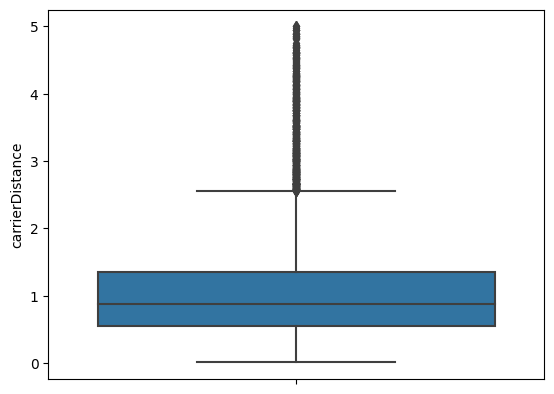

In [49]:
sns.boxplot(data=df[(df['event']=='tackle')&(df['isTackler']==1)], y='carrierDistance')

In [50]:
df.to_csv('new_df_filtered.csv')